In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import joblib
import os
import json


2024-11-16 00:08:23.204275: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 00:08:23.258549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 00:08:24.176432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load and preprocess data
df = pd.read_csv('data.csv')
x = np.array(df.iloc[:, :2])
y = np.array(df.iloc[:, 2])

scaler_x = StandardScaler()
x = scaler_x.fit_transform(x)

scaler_y = StandardScaler()
y = y.reshape(-1, 1)  # Reshape y to have one feature
y = scaler_y.fit_transform(y)

x = torch.from_numpy(x).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=666)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=666)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=512)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=512)


In [3]:
# Define the RNN model
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output=1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

# Instantiate the model
model = Net(hidden_dim=220, input_size=1, num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()


In [4]:
# Training the model
train_loss_list = []
val_loss_list = []
train_mae_list = []
val_mae_list = []
for epoch in range(250):
    model.train()
    train_loss = 0
    train_mae = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.reshape(-1, 2, 1)
        outputs = model(data)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_mae += mean_absolute_error(label.detach().numpy(), outputs.detach().numpy())
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    train_loss_list.append(train_loss)
    train_mae_list.append(train_mae)
    
    # Validation
    model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.reshape(-1, 2, 1)
            outputs = model(data)
            loss = criterion(outputs, label)
            val_loss += loss.item()
            val_mae += mean_absolute_error(label.detach().numpy(), outputs.detach().numpy())
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    val_loss_list.append(val_loss)
    val_mae_list.append(val_mae)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}, Train MAE: {train_mae:.8f}, Val MAE: {val_mae:.8f}')
    

Epoch: 1, Train Loss: 0.63025475, Val Loss: 0.49898196, Train MAE: 0.66181865, Val MAE: 0.59139446
Epoch: 2, Train Loss: 0.49275909, Val Loss: 0.49250727, Train MAE: 0.58554393, Val MAE: 0.58231184
Epoch: 3, Train Loss: 0.48349870, Val Loss: 0.47509713, Train MAE: 0.58015463, Val MAE: 0.57281128
Epoch: 4, Train Loss: 0.44220598, Val Loss: 0.39435453, Train MAE: 0.55400380, Val MAE: 0.52192322
Epoch: 5, Train Loss: 0.29921744, Val Loss: 0.19322610, Train MAE: 0.44910619, Val MAE: 0.35965427
Epoch: 6, Train Loss: 0.12871224, Val Loss: 0.09026372, Train MAE: 0.27751594, Val MAE: 0.22848398
Epoch: 7, Train Loss: 0.08717832, Val Loss: 0.08058624, Train MAE: 0.21571610, Val MAE: 0.21035297
Epoch: 8, Train Loss: 0.08214878, Val Loss: 0.07781319, Train MAE: 0.20567187, Val MAE: 0.20352866
Epoch: 9, Train Loss: 0.08075327, Val Loss: 0.07654775, Train MAE: 0.20228036, Val MAE: 0.20319572
Epoch: 10, Train Loss: 0.07946906, Val Loss: 0.07738087, Train MAE: 0.19971699, Val MAE: 0.19994631
Epoch: 11

In [20]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'rnnmodel.pth')

print("Model saved successfully to 'rnnmodel.pth'")

Model saved successfully to 'rnnmodel.pth'


In [20]:
# 保存模型和训练历史
model_path = './rnnmodel/model_rnn_weight.pth'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model.state_dict(), model_path)
print("Model saved to disk.")


Model saved to disk.


In [ ]:
# 保存训练历史
history = {
    'train_loss': train_loss_list,
    'val_loss': val_loss_list,
    'train_mae': train_mae_list,
    'val_mae': val_mae_list
}
history_path = './model/rnn_training_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f)
print("Training history saved to disk.")


Training history saved to disk.


In [4]:
# Load the model
model_path = './rnnmodel/model_rnn_weight.pth'
model = Net(hidden_dim=220, input_size=1, num_layers=2)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk.")
else:
    print("Model file not found.")
    

Model loaded from disk.


In [5]:
# Testing the model
model.eval()
test_loss = 0
output = torch.zeros(size=(1, 1))
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        data = data.reshape(-1, 2, 1)
        outputs = model(data)
        output = torch.cat((output, outputs), 0)
        loss = criterion(outputs, label)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test MSE: {test_loss:.8f}')

# Remove the initial zero
output = output[1:]

# Inverse transform
output = output.numpy()
y_test = y_test.numpy()
output = scaler_y.inverse_transform(output)
y_test = scaler_y.inverse_transform(y_test)

# Calculate Metrics
mse = mean_squared_error(y_test, output)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, output)
r2 = r2_score(y_test, output)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Test MSE: 0.06919063
Mean Squared Error (MSE): 13.895088195800781
Root Mean Squared Error (RMSE): 3.727611541748047
Mean Absolute Error (MAE): 2.640897750854492
R² Score: 0.9302578070073911


损失图已保存到: rnn_fig/rnn_loss_plot.png
局部放大损失图已保存到: rnn_fig/zoom_loss_plot.png


/tmp/ipykernel_85398/1508963212.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: rnn_fig/rnn_combined_plot.png


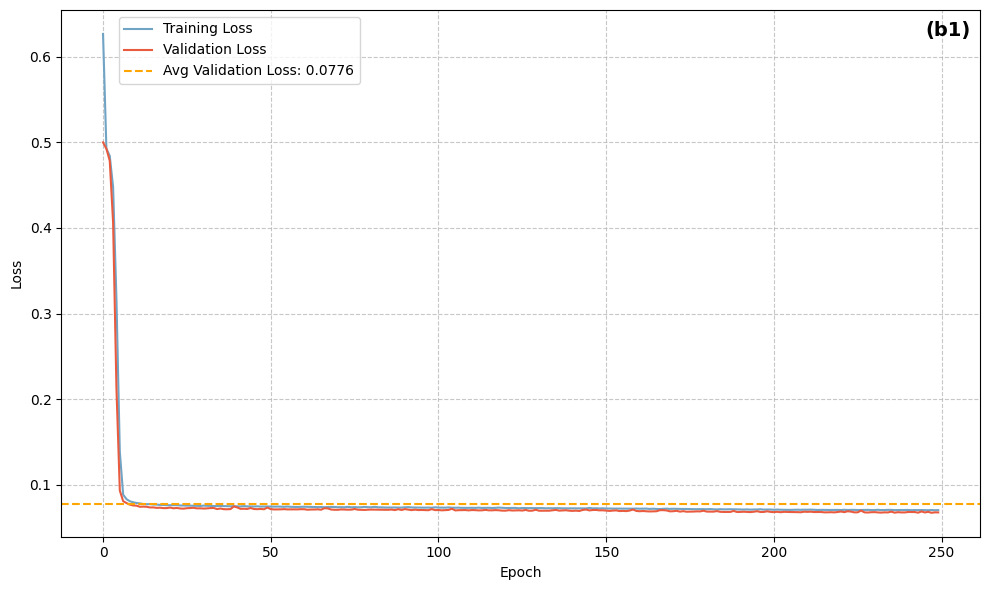

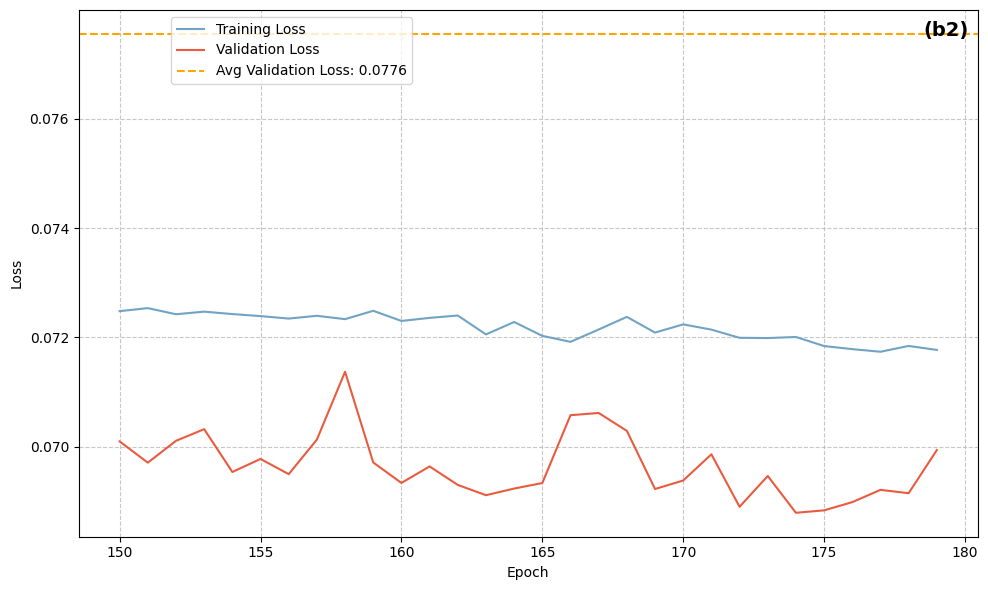

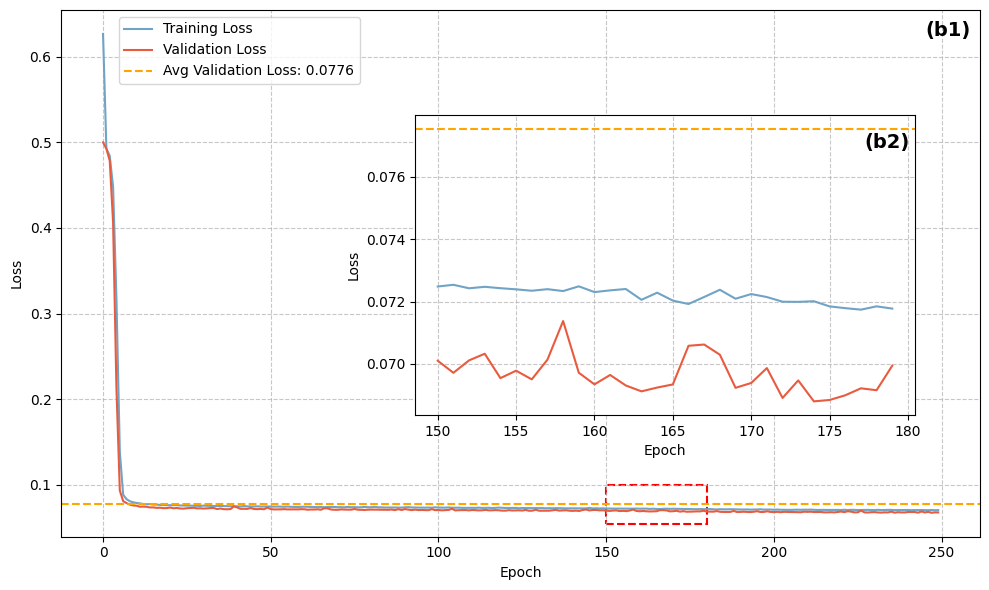

In [19]:
# 获取训练和验证 MAE
train_mae_list = train_mae_list  # 假设这些列表已经定义
val_mae_list = val_mae_list

# 获取训练和验证损失
train_loss_list = train_loss_list
val_loss_list = val_loss_list

# 计算平均验证损失和MAE
avg_val_loss = np.mean(val_loss_list)
avg_val_mae = np.mean(val_mae_list)

# 自定义放大区间
zoom_epoch_start = 150  # 自定义起始 epoch
zoom_epoch_end = 180    # 自定义结束 epoch

# 自定义虚线框高度
rect_y_min = 0.055  # 自定义虚线框的下边界
rect_y_max = 0.1 # 自定义虚线框的上边界

# 创建保存图片的文件夹
folder_name = "rnn_fig"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 绘制损失图
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss_list, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss_list, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(b1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'rnn_loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 绘制局部放大图
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss_list[zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss_list[zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.legend(loc='upper left', bbox_to_anchor=(0.095, 1), bbox_transform=ax2.transAxes)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(b2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# 绘制结合图，将局部放大图嵌入到主图中
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss_list, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss_list, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(b1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 嵌入放大损失图
inset_ax = fig.add_axes([0.42, 0.30, 0.5, 0.5])  # [left, bottom, width, height]
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss_list[zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss_list[zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')  # 添加平均值线
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.94, '(b2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 添加红色虚线框
rect = plt.Rectangle((zoom_epoch_start, rect_y_min), 
                     zoom_epoch_end - zoom_epoch_start, 
                     rect_y_max - rect_y_min, 
                     edgecolor='red', linestyle='--', linewidth=1.5, facecolor='none', transform=ax1.transData)
ax1.add_patch(rect)

# 添加标注和链接
ax1.annotate('', xy=(0.6, 0.45), xycoords='axes fraction', xytext=(0.45, 0.25), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=2))

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'rnn_combined_plot.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

# 显示图表
plt.show()

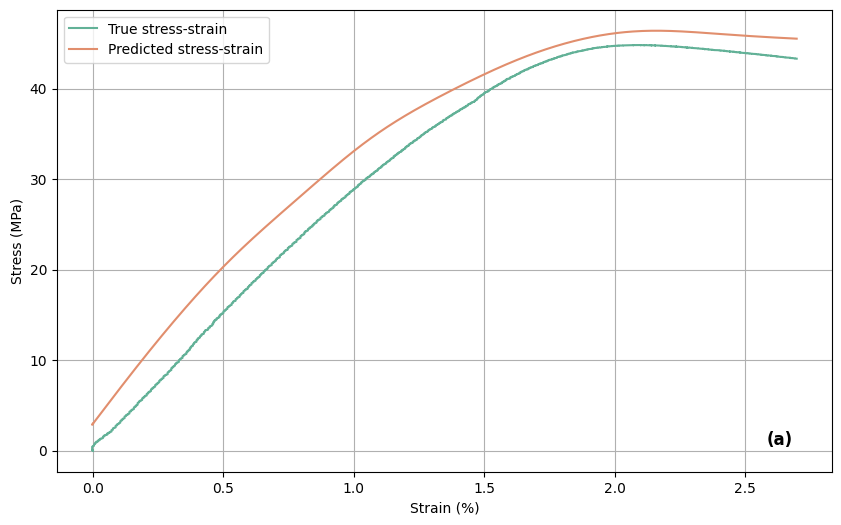

应力-应变曲线已保存并显示: rnn_fig/prediction/stress_strain_curve_angle_group_5.png


In [7]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 确保保存图片的文件夹存在
folder_path = os.path.join('rnn_fig', 'prediction')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# 读取新数据
file_name = 'Angle_group_5.csv'
df_new_data = pd.read_csv(file_name)

# 提取特征和真实值
strain = df_new_data.iloc[:, 1].values  # 假设第二列是应变值
stress_true = df_new_data.iloc[:, 2].values  # 第三列为真实应力值

# 对新数据进行归一化处理
x_new = df_new_data.iloc[:, :2].values  # 取前两列作为输入特征
x_new_scaled = scaler_x.transform(x_new)

# 转换为张量
x_new_tensor = torch.from_numpy(x_new_scaled).type(torch.FloatTensor).reshape(-1, 2, 1)

# 加载模型
model = Net(hidden_dim=220, input_size=1, num_layers=2)
model.load_state_dict(torch.load('./rnnmodel/model_rnn_weight.pth'))
model.eval()

# 进行预测
with torch.no_grad():
    stress_pred_scaled = model(x_new_tensor)

# 将预测值逆归一化，恢复到原始尺度
stress_pred = scaler_y.inverse_transform(stress_pred_scaled.numpy()).flatten()

# 确保预测值和实际值的长度相同
min_length = min(len(strain), len(stress_pred))
strain_truncated = strain[:min_length]
stress_true_truncated = stress_true[:min_length]
stress_pred_truncated = stress_pred[:min_length]

# 使用特定的应变阈值
strain_threshold = 2.7  # 根据之前的阈值设置
valid_indices = strain_truncated < strain_threshold
strain_truncated = strain_truncated[valid_indices]
stress_true_truncated = stress_true_truncated[valid_indices]
stress_pred_truncated = stress_pred_truncated[valid_indices]

# 绘制预测结果与真实值的对比图
plt.figure(figsize=(10, 6))
plt.plot(strain_truncated, stress_true_truncated, label='True stress-strain', color='#62B197')
plt.plot(strain_truncated, stress_pred_truncated, label='Predicted stress-strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.legend()
# plt.title('True vs Predicted Stress-Strain Curve (Angle Group 5)')
plt.grid(True)
# 在右下角添加文本 (b1)
plt.text(0.95, 0.05, '(a)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='bottom')
# 保存图像
save_path = os.path.join(folder_path, 'stress_strain_curve_angle_group_5.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"应力-应变曲线已保存并显示: {save_path}")

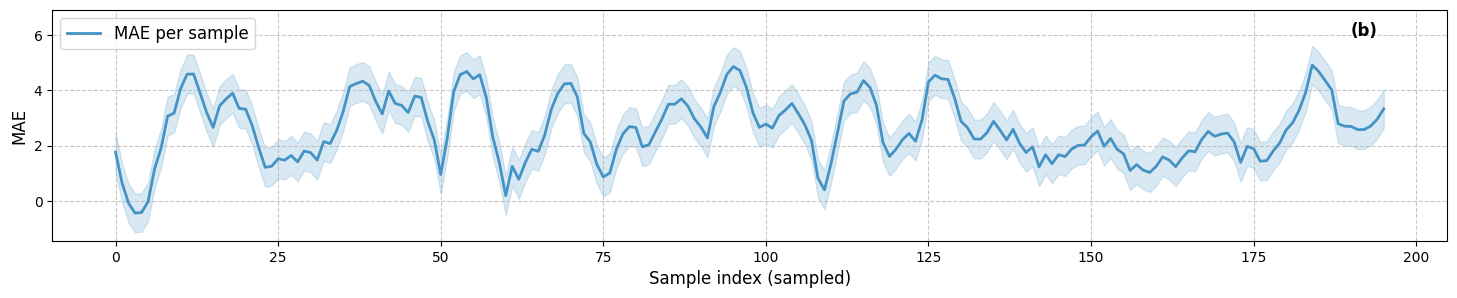

MAE per sample plot saved and displayed: ./rnn_fig/mae_per_sample.png


In [24]:
from scipy.signal import savgol_filter
# 计算每个样本的 MAE
mae_per_sample = np.abs(y_test - output).flatten()

# 采样数据以减少密度（例如，每隔250个点取一个）
sampling_rate =80
mae_sampled = mae_per_sample[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)

# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per sample', color='#4493C4', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.7  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='#4493C4', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本 (a)
plt.text(0.95, 0.95, '(b)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.xlabel('Sample index (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 调整 y 轴范围以增加图例和曲线之间的距离
plt.ylim(bottom=min(mae_smoothed) - 1, top=max(mae_smoothed) + 2)

# 保存图像
mae_timestep_path = './rnn_fig/mae_per_sample.png'
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per sample plot saved and displayed: {mae_timestep_path}")